# Twist Challenge: House Price Regression

The City of Cape Town wants to automate the valuation of properties in CapeTown based on various physical properties(size, number of bedrooms/bathrooms, location etc).


We aim to build a model that will be able to predict the prices of houses in CapeTown based on the features scraped from the property24 website https://www.property24.com/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [166]:
#import some necessary librairies

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='notebook', palette='viridis')
sns.despine(top=True,right=True)

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,LabelEncoder

<Figure size 432x288 with 0 Axes>

# Data Preparation

In [167]:
data_kel = pd.read_csv("/content/drive/My Drive/listings.csv")
data_cate = pd.read_csv("/content/drive/My Drive/final_cleaner.csv")

In [168]:
#data_kel.head()

data_kel.replace('nan', np.nan, inplace=True)
data_kel.replace('NaN', np.nan, inplace=True)

In [169]:
data_cate.replace('None', np.nan, inplace=True)
data_cate.replace('NaN', np.nan, inplace=True)
data_cate.isna().sum().sum()

2694

In [170]:
data_kel.head()

,Location,Price,Bedrooms,Bathrooms,Parking,Floor Size,Erf Size,Description
0,Waterfront,28000000,3.000,3.000,2.000,192.000,nan,NaN
1,Waterfront,55000000,3.000,3.500,2.000,410.000,nan,NaN
2,Constantia,5995000,3.000,3.000,3.000,nan,1487.000,"If Position, Presentation and Pric..."
3,Constantia,4950000,nan,nan,nan,nan,2448.000,NaN
4,Pinelands,1895000,2.000,1.000,2.000,75.000,nan,New release - Joint mandate.Move r...


## Merging Kelly's Data

In [171]:
# drop Erf and Description
data_kel = data_kel.drop(['Erf Size', 'Description'], axis = 1)

#make column names to lower
data_kel.columns= data_kel.columns.str.lower()

# renaming columns to match mine
data_kel.columns = ['location', 'price', 'bedrooms','bathrooms', 'parking', 'floor_size']

merged = data_cate.append(data_kel)
merged2 = merged.drop_duplicates()
len(merged2)

14922

## Dealing with Missing data

- Dropped rows with more than two NA's
- Filled bedrooms, bathrooms and garages with 0
- deleted rows with no price value

We decided to go with this approach mainly because of the little time that we had. If we had more time we could've explored why the data was missing and found ways of dealing with them such as imputation or predicting the missing values.

In [172]:
#drop rows with more than one NA
df = merged2.dropna(thresh=merged2.shape[1]-2)
df = df.copy()

In [173]:
#change garage to zero if NaN
df['parking'] = df['parking'].transform(lambda x: x.fillna(0))
df['bathrooms'] = df['bathrooms'].transform(lambda x: x.fillna(0))
df['bedrooms'] = df['bedrooms'].transform(lambda x: x.fillna(0))

In [174]:
df.isna().sum().sum()

3653

In [175]:
#drop all other missing values
df = df.dropna()

In [176]:
df.shape

(10469, 6)

Total Data Now becomes:

- **7679** rows of data
    - Features include:
     - location, price, floor_size, bathrooms, bedrooms, parking

In [177]:
#change NA to zero 
df = df.replace(np.nan, 0)

In [178]:
#checking for missing values
df.isna().sum().sum()

0

# Data Exploration and Preparation

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10469 entries, 0 to 8559
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    10469 non-null  object 
 1   price       10469 non-null  float64
 2   floor_size  10469 non-null  object 
 3   bathrooms   10469 non-null  object 
 4   bedrooms    10469 non-null  object 
 5   parking     10469 non-null  object 
dtypes: float64(1), object(5)
memory usage: 572.5+ KB


In [180]:
df = df.copy()

In [181]:
df['floor_size'] = df['floor_size'].apply(lambda x: str(x).replace(" ", "").split())
df['floor_size'] = df['floor_size'].apply(lambda x: str(x).replace("'", "").split())
df['floor_size'].replace('nan', np.nan, inplace=True)
import re
df['floor_size'] = df['floor_size'].apply(lambda x: re.sub("[^0-9]", "",str(x)))
df['floor_size'] = df['floor_size'].apply(lambda x: re.sub(r'(\d)\s+(\d)', r'\1\2', str(x)))

In [182]:
df["floor_size"] = pd.to_numeric(df["floor_size"])
df["bathrooms"] = pd.to_numeric(df["bathrooms"])
df["bedrooms"] = pd.to_numeric(df["bedrooms"])
df["parking"] = pd.to_numeric(df["parking"])
df["price"] = pd.to_numeric(df["price"])

In [183]:
df.describe()

,price,floor_size,bathrooms,bedrooms,parking
count,10469.000,10469.000,10469.000,10469.000,10469.000
mean,5277884.738,626.354,1.877,2.270,1.546
std,7634360.955,989.246,1.302,1.462,1.612
min,199000.000,17.000,0.000,0.000,0.000
25%,1795000.000,93.000,1.000,1.000,1.000
50%,2895000.000,420.000,1.500,2.000,1.000
75%,5385000.000,800.000,2.000,3.000,2.000
max,172500000.000,39423.000,30.000,33.000,30.000


From the above, we note that there might be outliers in the data looking at the min and max values of the features, we explore this further.

### split the data into train and test data

- **Train** - Train data will be used to train our final model, this will later be split again into Train and validation(80%) **6114** train <br/> 
- **Test** - Final data for evaluating how good our model performmed (20%) **1535** test

In [184]:
import sklearn
from sklearn.model_selection import train_test_split
import random

df = df.sample(frac=1).reset_index(drop=True)
test, train = sklearn.model_selection.train_test_split(df, train_size=0.2, test_size=0.8)
test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

In [185]:
print("Test shape:",test.shape)
print("Train shape:",train.shape)

Test shape: (2093, 6)
Train shape: (8376, 6)


In [186]:
# from pandas_profiling import ProfileReport
# eda_train = train.copy()
# ProfileReport(eda_train)

## Checking normality of our target variable

Skewed data can mess up the power of the predictive model if it is not addressed correctly.
drawing a graph will let us know how the price values are distributed and we can start estimating the probability of events.

Helps us to understand how far the data is from the mean.


In [187]:
train['price'].skew()

5.589243052181511


 mu = 5227862.52 and sigma = 7498442.84



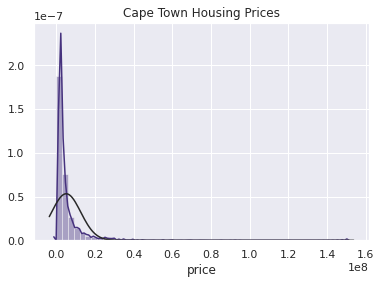

In [188]:
# Checking if our target variable is normally skewed
import seaborn as sns
def checkskew(col):
    sns.distplot(train[col],fit=norm).set_title("Cape Town Housing Prices")
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
checkskew('price')

In [189]:
# removing skewness from the predictor
train['price2'] = np.log(train['price'])
train['price2'].skew()

0.7304277053245446

In [190]:
test['price2'] = np.log(test['price'])
test['price2'].skew()

0.74806477488216


 mu = 15.01 and sigma = 0.87



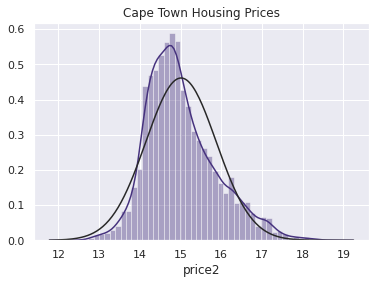

In [191]:
checkskew('price2')

### Checking for outliers

In [192]:
print("max floor_size:", max(train['floor_size']))
print("min floor_size:", min(train['floor_size']))

max floor_size: 22030
min floor_size: 17


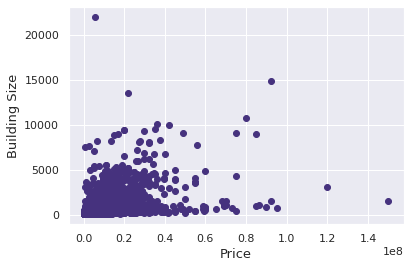

In [193]:
fig, plot = plt.subplots()
plot.scatter(x= train['price'], y = train['floor_size'])
plt.ylabel('Building Size', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

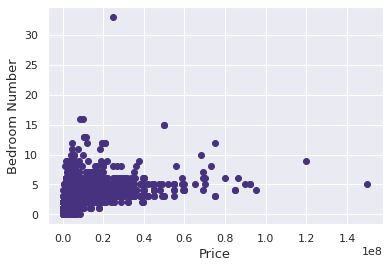

In [194]:
fig, plot = plt.subplots()
plot.scatter(x= train['price'], y= train['bedrooms'])
plt.ylabel('Bedroom Number', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

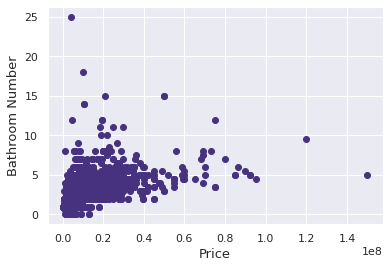

In [195]:
fig, plot = plt.subplots()
plot.scatter(x= train['price'], y= train['bathrooms'])
plt.ylabel('Bathroom Number', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

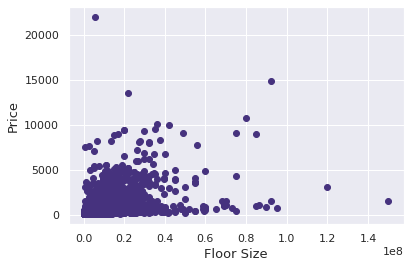

In [196]:
fig, plot = plt.subplots()
plot.scatter(x= train['price'], y= train['floor_size'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Floor Size', fontsize=13)
plt.show()

## Feature Engineering
#### Creating new column showing number of houses in each location

In [197]:
train['num_houses'] = train['location'].groupby(train['location']).transform('count')
test['num_houses'] = test['location'].groupby(test['location']).transform('count')

In [198]:
train
#(train.groupby(by=(['location'])[num_houses], as_index=False).sum())

,location,price,floor_size,bathrooms,bedrooms,parking,price2,num_houses
0,Sea Point,4500000.000,83,1.000,2.000,1.000,15.320,474
1,Marina Da Gama,2490000.000,243,2.000,3.000,2.000,14.728,37
2,Zonnebloem,1150000.000,41,1.000,1.000,1.000,13.955,151
3,Observatory,2150000.000,65,2.000,2.000,1.000,14.581,255
4,Camps Bay,5495000.000,101,2.000,2.000,2.000,15.519,172
...,...,...,...,...,...,...,...,...
8371,CapeTownCityCentre,6999000.000,2970,3.000,3.000,2.000,15.761,449
8372,Clifton,55000000.000,3550,4.500,5.000,4.000,17.823,51
8373,Plumstead,2695000.000,615,2.000,3.000,5.000,14.807,147
8374,Mowbray,1290000.000,60,1.000,2.000,1.000,14.070,53


In [199]:
#train.loc[train['location'] == "Sea Point"].count()

### Kmeans clustering to see if there are groups formed by the features

In [200]:
import matplotlib.pyplot as plt
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [201]:
train.shape

(8376, 8)

In [202]:
#find the optimal number of clusters in out data

X = train.iloc[:, [1,4]].values

In [203]:
from sklearn.cluster import KMeans
#wcss = within cluster sum of squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

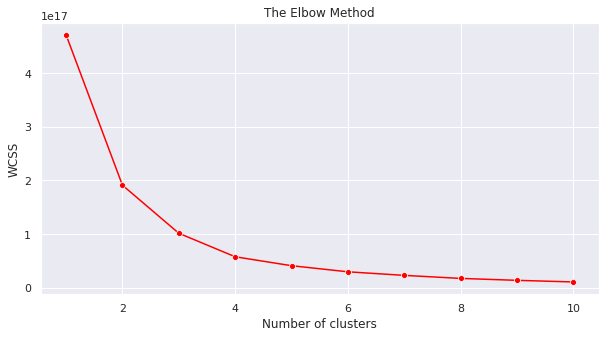

In [204]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [205]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
cl = kmeans.fit_predict(train[['price', 'floor_size', 'bathrooms', 'bedrooms']])
cl_test= kmeans.fit_predict(test[['price', 'floor_size', 'bathrooms', 'bedrooms']])
train['cluster'] = cl
test['cluster'] = cl_test

In [206]:
# Fitting K-Means to the dataset
#kmeans = KMeans(n_clusters=3,random_state=42 )

# Fitting K-Means to the dataset

y_kmeans = kmeans.fit_predict(X)


In [207]:
train.shape

(8376, 9)

### visualizations

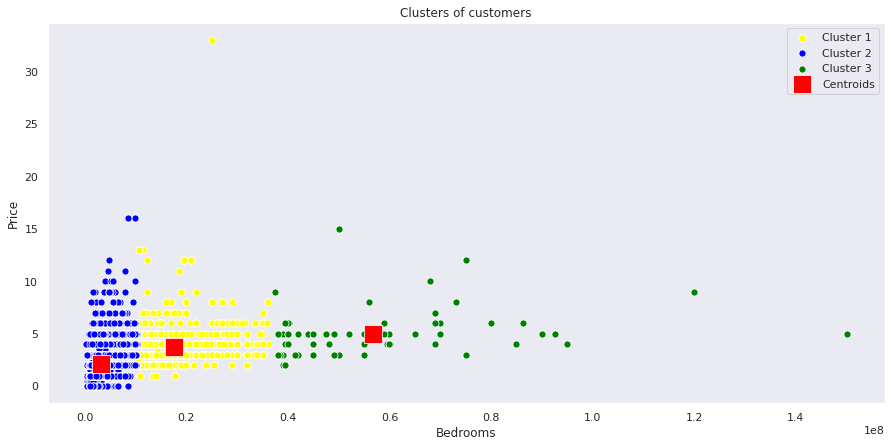

In [208]:
# Visualising the clusters
plt.figure(figsize=(15,7))
sns.scatterplot(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], color = 'orange', label = 'Cluster 5',s=50)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', 
                label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('Clusters of customers')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.legend()
plt.show()

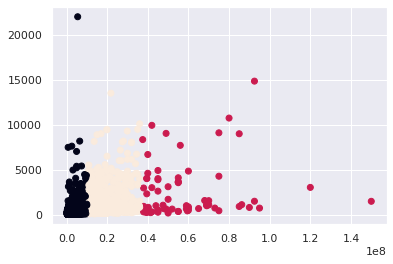

In [209]:
import matplotlib.pyplot as plt
plt.scatter(train['price'], train['floor_size'], c = train['cluster'])

### checking how each column correlates with the target


In [210]:
train[train.columns].corr()['price2'][:]

price         0.801
floor_size    0.446
bathrooms     0.674
bedrooms      0.536
parking       0.415
price2        1.000
num_houses   -0.001
cluster       0.688
Name: price2, dtype: float64

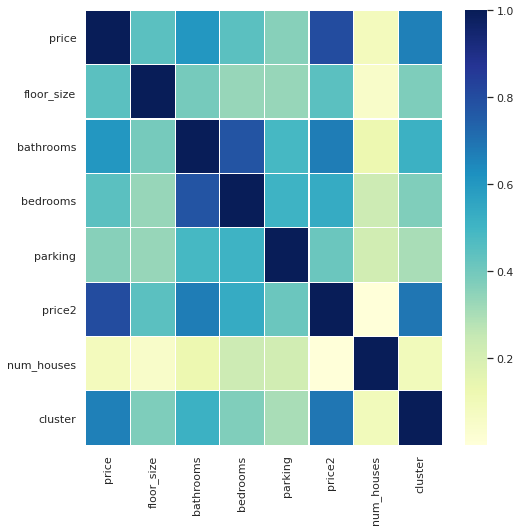

In [211]:
#checking correlation with each other

corr_matrix= train.iloc[:, 1:].corr().abs()

f, ax = plt.subplots(figsize =(8, 8))
sns.heatmap(corr_matrix, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [212]:
# transform the categorical variable location to numerical variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['location'] = le.fit_transform(train['location'])
test['location'] = le.fit_transform(test['location'])

In [213]:
train.head(2)

,location,price,floor_size,bathrooms,bedrooms,parking,price2,num_houses,cluster
0,129,4500000.000,83,1.000,2.000,1.000,15.320,474,0
1,86,2490000.000,243,2.000,3.000,2.000,14.728,37,0


In [214]:
test.head(2)

,location,price,floor_size,bathrooms,bedrooms,parking,price2,num_houses,cluster
0,16,1950000.000,43,1.000,0.500,1.000,14.483,111,0
1,16,2295000.000,65,1.000,1.000,0.000,14.646,111,0


In [215]:
train.drop(['price', 'num_houses'], axis = 1, inplace = True)
test.drop(['price', 'num_houses'], axis = 1, inplace = True)

# Modeling

## Linear Regression

Linear Regression has downsides such as:

- It requres multiple assumtions such as:
  - Assuming that thre relationship between predictors and target variables are linear
  - There are no outliers in the data
  - No highly correlated features
  - predicters and target variables are normally distributed
  - scaled predictors



**Performance evaluation method that was used was Root Mean Squared Error**

### Split the data to create train, validation set

In [216]:
y = train['price2']
train = train.drop(['price2'], axis = 1)

In [217]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
new_train = sc_X.fit_transform(train)
new_test = sc_X.fit_transform(test)

In [218]:
X_train, X_test, y_train, y_test = train_test_split(new_train, y, test_size = 0.2, random_state=42)
print(X_train.shape, y_train.shape)

(6700, 6) (6700,)


In [219]:
# Fit a basic linear regression model
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [220]:
pred = lm.predict(X_test)

In [221]:
lm.score(X_test,y_test)

0.610989647771852

In [222]:
#evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(y_test, pred)))


RMSE: 0.5381417081656177


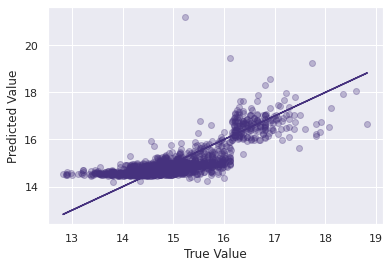

In [223]:
# Plot predicted vs actual
plt.scatter(y_test, pred, alpha=0.3)
plt.plot(y_test, y_test) # A straight line - we want to be close to this
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

## Random Forest Regressor

In [58]:
! pip install catboost

     |████████████████████████████████| 66.1MB 53kB/s 


In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [140]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.9min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [141]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 77,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [142]:
rf = RandomForestRegressor(**rf_random.best_params_)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=77, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [143]:
pred = rf.predict(X_test)

In [144]:
print("RMSE:", sqrt(mean_squared_error(y_test, pred)))

RMSE: 0.3015268190501512


# CatBoost

In [229]:
# clf = CatBoostRegressor()
# params = {'iterations': [400,500, 600,1000],
#           'depth': [4, 5, 6],
#           'loss_function': ['RMSE'],
#           'l2_leaf_reg': np.logspace(-20, -19, 3),
#           'leaf_estimation_iterations': [5,10, 30,50,70],
#           'learning_rate': [0.07,0.05,0.1,0.5,.7],
#           'logging_level':['Silent'],
#           'random_seed': [42]
#          }
# clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=3)
# clf_grid.fit(X_train, y_train)

In [147]:
params={'depth': 4,
 'iterations': 600,
 'l2_leaf_reg': 1e-2,
 'leaf_estimation_iterations': 5,
 'learning_rate': 0.07,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'random_seed': 42}

In [149]:
#params = clf_grid.best_params_
cb_model=CatBoostRegressor(**params)
cb_model.fit(X_train, y_train)

In [151]:
pred = cb_model.predict(X_test)
print("RMSE:", sqrt(mean_squared_error(y_test, pred)))

RMSE: 0.2879075410140764


## Ensembling the Models


In [224]:
y = test['price2']
test = test.drop(['price2'], axis = 1)

In [225]:
test.head()

,location,floor_size,bathrooms,bedrooms,parking,cluster
0,16,43,1.000,0.500,1.000,0
1,16,65,1.000,1.000,0.000,0
2,45,72,1.000,1.000,0.000,0
3,76,86,2.000,2.000,1.000,0
4,76,380,1.000,2.000,1.000,0


In [226]:
X_test_pred = (cb_model.predict(test)+rf.predict(test))/2

In [227]:
# final model performance

print("RMSE:", sqrt(mean_squared_error(y, X_test_pred)))

RMSE: 0.6870009239016809
